# Test comptage de mot

- Test actuellement KO. Essayer de suivre [ce tuto](https://www.knowledgehut.com/blog/big-data/install-spark-on-ubuntu) avec version antierieure pour etre sur que cela peut fonctionner.

In [1]:
import os

print("SPARK_HOME :", os.environ['SPARK_HOME'])
print("JAVA_HOME : ", os.environ['JAVA_HOME'])

SPARK_HOME : /opt/spark-3.2.4-bin-hadoop2.7
JAVA_HOME :  /opt/jdk/jdk1.8.0_202


In [2]:
# from pyspark import SparkContext
#
# # Instantiation d'un SparkContext
# sc = SparkContext()
#
# # Lecture d'un fichier texte : le fichier est décomposé en lignes.
# lines = sc.textFile("./example/text.txt")
#
# # Décomposition de chaque ligne en mots
# word_counts = (lines.flatMap(lambda line: line.split(' '))
#                    # Chacun des mots est transformé en une clé-valeur
#                    .map(lambda mot: (mot, 1))
#                    # Les valeurs associées à chaques clé sont sommées
#                    .reduceByKey(lambda count1, count2: count1 + count2)
#                    # Le résultat est récupéré
#                    .collect())
#
# # Chaque paire (clé, valeur) est affichée
# for (word, count) in word_counts:
#     print(word, count)

# 3. Déploiement de la solution en local


## 3.1 Environnement de travail

Pour des raisons de simplicité, nous développons dans un environnement <br />
Linux Unbuntu (exécuté depuis une machine Windows dans une machine virtuelle)
* Pour installer une machine virtuelle :  https://www.malekal.com/meilleurs-logiciels-de-machine-virtuelle-gratuits-ou-payants/

## 3.2 Installation de Spark

[La première étape consiste à installer Spark ](https://computingforgeeks.com/how-to-install-apache-spark-on-ubuntu-debian/)

## 3.3 Installation des packages

<u>On installe ensuite à l'aide de la commande **pip** <br />
les packages qui nous seront nécessaires</u> :

In [3]:
!pip install Pandas pillow tensorflow pyspark pyarrow


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## 3.4 Import des librairies

In [4]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

2023-07-25 11:18:38.017596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# import findspark
# findspark.init()

## 3.5 Définition des PATH pour charger les images <br /> et enregistrer les résultats

Dans cette version locale nous partons du principe que les données <br />
sont stockées dans le même répertoire que le notebook.<br />
Nous n'utilisons qu'un extrait de **300 images** à traiter dans cette <br />
première version en local.<br />
L'extrait des images à charger est stockée dans le dossier **Test1**.<br />
Nous enregistrerons le résultat de notre traitement <br />
dans le dossier "**Results_Local**"

In [6]:
PATH = os.getcwd()
# PATH_Data = PATH+'/data/Test1'
# PATH_Result = PATH+'/data/Results'
PATH_Data = PATH+'/data'
PATH_Result = PATH+'/results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /home/maximorose/git_repositories/oc-ds-p08
PATH_Data:   /home/maximorose/git_repositories/oc-ds-p08/data
PATH_Result: /home/maximorose/git_repositories/oc-ds-p08/results


## 3.6 Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**. <br />
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur <br />
dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

<u>Ici nous créons une session spark en spécifiant dans l'ordre</u> :
 1. un **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**P8**"
 2. que l'application doit s'exécuter **localement**. <br />
   Nous ne définissons pas le nombre de cœurs à utiliser (comme .master('local[4]) pour 4 cœurs à utiliser), <br />
   nous utiliserons donc tous les cœurs disponibles dans notre processeur.<br />
 3. une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** <br />
   que nous utiliserons pour enregistrer et charger le résultat de notre travail.
 4. vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle

In [7]:
# Probleme : https://stackoverflow.com/questions/69763427/pyspark-not-initialized/71855571#71855571
# Parametre originaux : "spark.sql.parquet.writeLegacyFormat", 'true'
# Test config : .config("spark.driver.host", 'localhost')

spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

23/07/25 11:18:40 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.15 instead (on interface wlp0s20f3)
23/07/25 11:18:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/25 11:18:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [8]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [9]:
spark

In [10]:
# SparkSession.builder.appName("test").config(
#     "spark.driver.extraJavaOptions",
#     "--add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED",
# ).getOrCreate()

In [11]:
print(f'The PySpark {spark.version} version is running...')

The PySpark 3.2.4 version is running...


## 3.7 Traitement des données

<u>Dans la suite de notre flux de travail, <br />
nous allons successivement</u> :
1. Préparer nos données
    1. Importer les images dans un dataframe **pandas UDF**
    2. Associer aux images leur **label**
    3. Préprocesser en **redimensionnant nos images pour <br />
       qu'elles soient compatibles avec notre modèle**
2. Préparer notre modèle
    1. Importer le modèle **MobileNetV2**
    2. Créer un **nouveau modèle** dépourvu de la dernière couche de MobileNetV2
3. Définir le processus de chargement des images et l'application <br />
   de leur featurisation à travers l'utilisation de pandas UDF
3. Exécuter les actions d'extraction de features
4. Enregistrer le résultat de nos actions
5. Tester le bon fonctionnement en chargeant les données enregistrées




### 3.7.1 Chargement des données

Les images sont chargées au format binaire, ce qui offre, <br />
plus de souplesse dans la façon de prétraiter les images.

Avant de charger les images, nous spécifions que nous voulons charger <br />
uniquement les fichiers dont l'extension est **jpg**.

Nous indiquons également de charger tous les objets possibles contenus <br />
dans les sous-dossiers du dossier communiqué.

In [12]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

<u>Affichage des 5 premières images contenant</u> :
 - le path de l'image
 - la date et heure de sa dernière modification
 - sa longueur
 - son contenu encodé en valeur hexadécimal

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [13]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------------------------------+--------+
|path                                                                        |label   |
+----------------------------------------------------------------------------+--------+
|file:/home/maximorose/git_repositories/oc-ds-p08/data/Beetroot/r_171_100.jpg|Beetroot|
|file:/home/maximorose/git_repositories/oc-ds-p08/data/Beetroot/r_174_100.jpg|Beetroot|
|file:/home/maximorose/git_repositories/oc-ds-p08/data/Beetroot/r_175_100.jpg|Beetroot|
|file:/home/maximorose/git_repositories/oc-ds-p08/data/Beetroot/r_170_100.jpg|Beetroot|
|file:/home/maximorose/git_repositories/oc-ds-p08/data/Beetroot/r_173_100.jpg|Beetroot|
+----------------------------------------------------------------------------+--------

### 3.7.2 Préparation du modèle

Je vais utiliser la technique du **transfert learning** pour extraire les features des images.<br />
J'ai choisi d'utiliser le modèle **MobileNetV2** pour sa rapidité d'exécution comparée <br />
à d'autres modèles comme *VGG16* par exemple.

Pour en savoir plus sur la conception et le fonctionnement de MobileNetV2, <br />
je vous invite à lire [cet article](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c).

<u>Voici le schéma de son architecture globale</u> : 

![Architecture de MobileNetV2](img/mobilenetv2_architecture.png)

Il existe une dernière couche qui sert à classer les images <br />
selon 1000 catégories que nous ne voulons pas utiliser.<br />
L'idée dans ce projet est de récupérer le **vecteur de caractéristiques <br />
de dimensions (1,1,1280)** qui servira, plus tard, au travers d'un moteur <br />
de classification à reconnaitre les différents fruits du jeu de données.

Comme d'autres modèles similaires, **MobileNetV2**, lorsqu'on l'utilise <br />
en incluant toutes ses couches, attend obligatoirement des images <br />
de dimension (224,224,3). Nos images étant toutes de dimension (100,100,3), <br />
nous devrons simplement les **redimensionner** avant de les confier au modèle.

<u>Dans l'odre</u> :
 1. Nous chargeons le modèle **MobileNetV2** avec les poids **précalculés** <br />
    issus d'**imagenet** et en spécifiant le format de nos images en entrée
 2. Nous créons un nouveau modèle avec:
  - <u>en entrée</u> : l'entrée du modèle MobileNetV2
  - <u>en sortie</u> : l'avant dernière couche du modèle MobileNetV2

In [14]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

2023-07-25 11:18:45.212979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 11:18:45.214034: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle où nous constatons <br />
que <u>nous récupérons bien en sortie un vecteur de dimension (1, 1, 1280)</u> :

In [16]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Tous les workers doivent pouvoir accéder au modèle ainsi qu'à ses poids. <br />
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser <br />
ensuite les poids aux différents workers.

In [17]:
brodcast_weights = sc.broadcast(new_model.get_weights())

<u>Mettons cela sous forme de fonction</u> :

In [18]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### 3.7.3 Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

Ce notebook définit la logique par étapes, jusqu'à Pandas UDF.

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [19]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    """
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/maximorose/anaconda3/envs/oc_ds_p8/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### 3.7.4 Exécution des actions d'extraction de features

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), <br />
peuvent rencontrer des erreurs de type Out Of Memory (OOM).<br />
Si vous rencontrez de telles erreurs dans la cellule ci-dessous, <br />
essayez de réduire la taille du lot Arrow via 'maxRecordsPerBatch'

Je n'utiliserai pas cette commande dans ce projet <br />
et je laisse donc la commande en commentaire.

In [20]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.

<u>REMARQUE</u> : Cela peut prendre beaucoup de temps, tout dépend du volume de données à traiter. <br />

Notre jeu de données de **Test** contient **22819 images**. Cependant, dans l'exécution en mode **local**, nous <u>traiterons un ensemble réduit de **330 images**</u>.

In [21]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [22]:
print(PATH_Result)

/home/maximorose/git_repositories/oc-ds-p08/results


<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [23]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2023-07-25 11:18:48.416446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 11:18:49.443512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 11:18:49.444768: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2/2 [==============================] 

## 3.8 Chargement des données enregistrées et validation du résultat

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [24]:
df_source = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>On affiche les 5 premières lignes du DataFrame</u> :

In [25]:
df_source.shape

(1123, 3)

In [26]:
df_source.head()

,path,label,features
0,file:/home/maximorose/git_repositories/oc-ds-p...,Beetroot,"[0.0, 0.0, 0.0, 0.0, 0.11514753, 0.0, 2.300177..."
1,file:/home/maximorose/git_repositories/oc-ds-p...,Beetroot,"[0.18769681, 0.0, 0.0, 0.0, 0.019763187, 0.0, ..."
2,file:/home/maximorose/git_repositories/oc-ds-p...,Beetroot,"[0.07242505, 0.0109802075, 0.08189696, 0.01542..."
3,file:/home/maximorose/git_repositories/oc-ds-p...,Beetroot,"[0.03269247, 0.0, 0.0, 0.0, 0.18936272, 0.0, 0..."
4,file:/home/maximorose/git_repositories/oc-ds-p...,Apple Braeburn,"[0.013541436, 0.0014538667, 0.0, 0.0, 0.0, 0.1..."


<u>On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280</u> :

In [27]:
# 25-07-23
df_pys_source = spark.read.parquet(PATH_Result)
df_pys_source.select('features').show(3)

+--------------------+
|            features|
+--------------------+
|[0.13196293, 0.04...|
|[0.47461498, 0.0,...|
|[0.12090193, 0.0,...|
+--------------------+
only showing top 3 rows



In [28]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

# Les données images sont converties au format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
df = df_pys_source.withColumn('features', ud_f('features'))

In [29]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



# ACP PySpark sur features


Dans cette version de l'ACP ma conversion du dataframe d'entree pourrait surement etre plus efficace. Eventuellement en pyspark natif. Disons qu'elle passe par la creation d'un dataframe intermediaire compose des valeurs de la colonne "features", reorganisees pour pouvoir appliquer facilement un VectorAssembler. Ainsi, j'obtiens le format necessaire a l'execution des modeles PySpark. En termes de performances on peut surement mieux faire.

- Aide de [cette video](https://www.youtube.com/watch?v=Om7G2qRBSVw) pour comprendre un peu comment realiser des conversions pour travailler avec les types propres a PySpark.

## 0. Standard Scaling sklearn

In [30]:
# from sklearn.preprocessing import StandardScaler
#
# # Initialize an empty list to store the numpy arrays
# numpy_arrays = [feature for feature in df_source['features'].values]
# # Create a new DataFrame with the extracted numpy arrays
# new_df = pd.DataFrame(numpy_arrays)
#
# ss_df = pd.DataFrame(StandardScaler().fit_transform(new_df))
# ss_df.head(2)

In [31]:
# new_df_spark = spark.createDataFrame(ss_df)

In [32]:
# from pyspark.ml.feature import VectorAssembler
#
# colonne_name = [f"{i}" for i in range(new_df.shape[1])]
# v_asmblr =  VectorAssembler(inputCols=colonne_name, outputCol='vectorized_features')
# df = v_asmblr.transform(new_df_spark)

## 0.1. Standard Scaling pyspark

In [33]:
from pyspark.ml.feature import StandardScaler
#
# v_asmblr =  VectorAssembler(inputCols="features", outputCol='vectorized_features')
# df_ass = v_asmblr.transform(df_pys_source)



In [34]:
standardizer = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")
scalerModel = standardizer.fit(df)
scaled_data = scalerModel.transform(df)

## 1. Fit PCA

Je choisis de faire une PCA avec k=9. Cela permettra de faire une Scree-plot, puis de n'utiliser que les deux premieres composantes principales pour visualiser les categories sur un plan.

In [35]:
from pyspark.ml.feature import PCA

In [36]:
k=9
pca = PCA(k=k, inputCol="scaled_features") # k = 2 : on ne peut que les deux premieres composantes principales
pca.setOutputCol("pca_features")

PCA_6f7092af7998

In [37]:
model = pca.fit(scaled_data)
model.getK()

23/07/25 11:19:36 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/07/25 11:19:36 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


9

Attention : quand on collecte, il faut s'assurer que le noeud maitre dispose de suffisament de memoire ou de stockage.

In [38]:
output_df = model.transform(scaled_data)

In [39]:
print("Type output PCA transform : ", type(output_df))

Type output PCA transform :  <class 'pyspark.sql.dataframe.DataFrame'>


In [40]:
output_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



In [41]:
pca_features = output_df.select('pca_features').collect()

In [42]:
# print("Collected VECTORIZED_FEATURES caracteristiques")
# print("----------------------------------------------")
# print("Type : ", type(vectorized_features))
# print("Taille : ", len(vectorized_features))
# print("Type item[0] : ", type(vectorized_features[0]))

_vectorized features_ n'est rien d'autre que nos features qui ont servi d'input a l'execution de notre PCA. C'est-a-dire que ce sont les images vectorisees avec notre reseau de deep learning.

In [43]:
print("Collected PCA_FEATURES caracteristiques")
print("----------------------------------------------")
print("Type : ", type(pca_features))
print("Taille : ", len(pca_features))
print("Type item[0] : ", type(pca_features[0]))

Collected PCA_FEATURES caracteristiques
----------------------------------------------
Type :  <class 'list'>
Taille :  1123
Type item[0] :  <class 'pyspark.sql.types.Row'>


In [44]:
pca_features[0]

Row(pca_features=DenseVector([-10.987, -0.0224, 0.0157, 0.0041, 0.0035, -0.0137, 0.0227, -0.0026, -0.023]))

In [45]:
def transform_list_of_vect_to_df(vectlist) :
    return pd.DataFrame([[vectlist[j][0][i] for i in range(k)] for j in range(len(vectlist))])

In [46]:
transform_list_of_vect_to_df(pca_features).head(2)

,0,1,2,3,4,5,6,7,8
0,-10.987002,-0.022351,0.015722,0.004136,0.003459,-0.013660,0.022659,-0.002583,-0.022962
1,-9.342380,0.015570,0.006882,-0.013330,-0.017198,-0.038842,-0.020923,-0.027630,-0.042589


_pca features_ ce sont les coordonnees de nos points dans notre nouveau referentiel definis par les vecteurs des composantes principales. Chaque point de donnee est exprime selon les k axes de nos CP.

In [47]:
pca_coord_pf1 = transform_list_of_vect_to_df(pca_features).iloc[:, :2]
pca_coord_pf1.head(2)

,0,1
0,-10.987002,-0.022351
1,-9.342380,0.015570


## 2. PCA Analysis

### Scree plot on k9

In [48]:
v_explained_variance = model.explainedVariance
v_explained_variance

DenseVector([0.0274, 0.0207, 0.0202, 0.0193, 0.0186, 0.0179, 0.0171, 0.017, 0.0163])

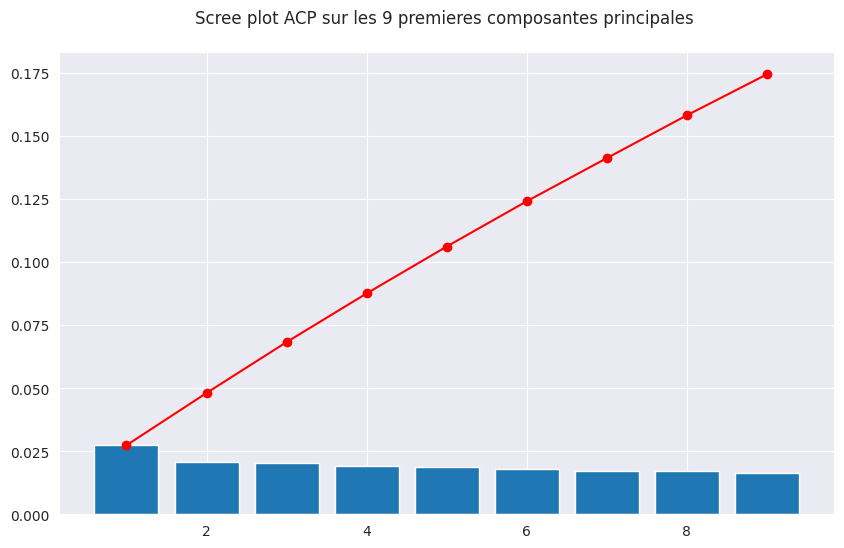

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

x_list = range(1, k+1)
scree_values = v_explained_variance.toArray()
plt.figure(figsize=(10, 6))
plt.bar(x_list, scree_values)
plt.plot(x_list, np.cumsum(scree_values), color='r', marker='o')
plt.title(f"Scree plot ACP sur les {k} premieres composantes principales \n")
plt.show()

### Representation sur le premier plan factoriel

In [50]:
df_source.head(2)

,path,label,features
0,file:/home/maximorose/git_repositories/oc-ds-p...,Beetroot,"[0.0, 0.0, 0.0, 0.0, 0.11514753, 0.0, 2.300177..."
1,file:/home/maximorose/git_repositories/oc-ds-p...,Beetroot,"[0.18769681, 0.0, 0.0, 0.0, 0.019763187, 0.0, ..."


In [51]:
chemin_tst = df_source["path"].values[0]

In [52]:
def get_fruit_name(chemin, parent_folder='data') :
    dossier_images_parent = parent_folder
    nom_fruit = chemin.split(dossier_images_parent)[-1].split('/')[1] # Premier "/" est le debut de l'adresse
    cat_fruits = nom_fruit.split(' ')[0]
    return  nom_fruit, cat_fruits


In [53]:
fruit_list = [get_fruit_name(chemin=chemin)[0]  for chemin in df_source['path'].values]
cat_fruit_list = [get_fruit_name(chemin=chemin)[1]  for chemin in df_source['path'].values]

In [54]:
pca_coord_pf1['fruit'] = fruit_list
pca_coord_pf1['cat_fruit'] = cat_fruit_list
pca_coord_pf1.head(2)

,0,1,fruit,cat_fruit
0,-10.987002,-0.022351,Beetroot,Beetroot
1,-9.342380,0.015570,Beetroot,Beetroot


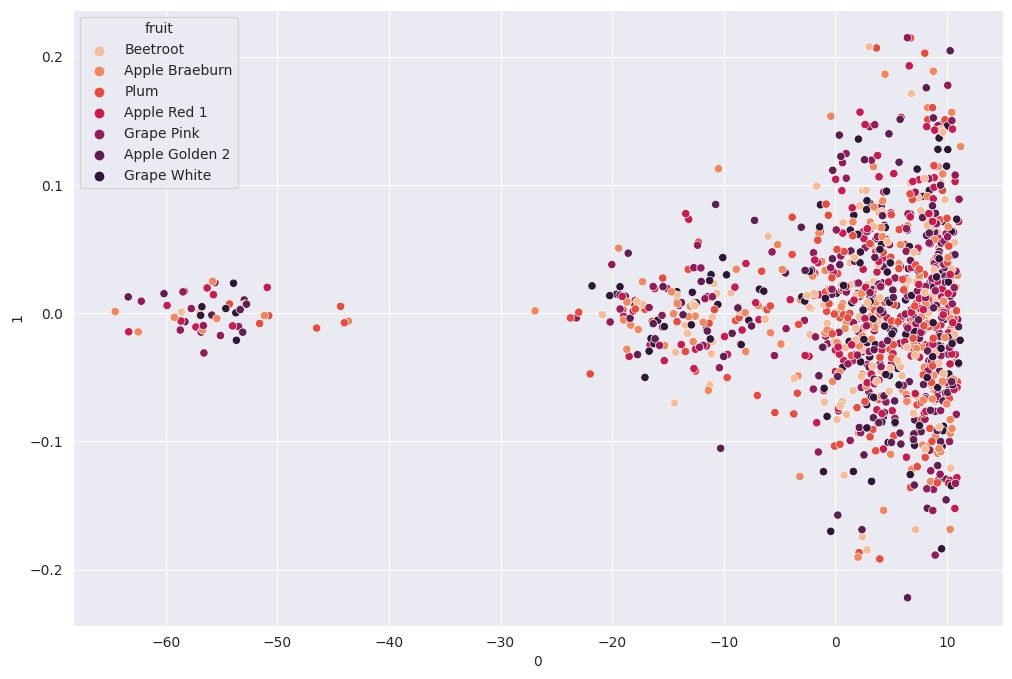

In [55]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_coord_pf1, x=0, y=1, hue='fruit', palette="rocket_r")
plt.show()

# Amelioration continue

Utiliser des fonctions natives de PySpark pour pipeliner le traitement :
- Standard Scaling, cf. [ici](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html)

In [56]:
pca_coord_pf1[0]

0      -10.987002
1       -9.342380
2       -6.017472
3      -11.246825
4        6.056103
          ...    
1118     9.191974
1119     9.471952
1120     9.304081
1121     8.230635
1122     9.067898
Name: 0, Length: 1123, dtype: float64